In [0]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [0]:

import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [0]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [0]:
def norm(inImg, inMask):
  inImg = tf.cast(inImg, tf.float32) / 255.0
  inMask -= 1
  return inImg, inMask

In [0]:
@tf.function
def loadImgTrain(datapt):
  inImg = tf.image.resize(datapt['image'], (128, 128))
  inMask = tf.image.resize(datapt['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > .5:
    inImg = tf.image.flip_left_right(inImg)
    inMask = tf.image.flip_left_right(inMask)
  
  inImg, inMask = norm(inImg, inMask)
  return inImg, inMask

In [0]:
def loadImgTest(datapt):
  inImg = tf.image.resize(datapt['image'], (128, 128))
  inMask = tf.image.resize(datapt['segmentation_mask'], (128, 128))

  inImg, inMask = norm(inImg, inMask)
  return inImg, inMask

In [0]:
TRAIN_LEN = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LEN / BATCH_SIZE

In [0]:
train = dataset['train'].map(loadImgTrain, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(loadImgTest)

In [0]:
trainData = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
trainData = trainData.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
testData = test.batch(BATCH_SIZE)

In [0]:
def display(displayList):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(displayList)):
    plt.subplot(1, len(displayList), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(displayList[i]))
    plt.axis('off')
  plt.show()

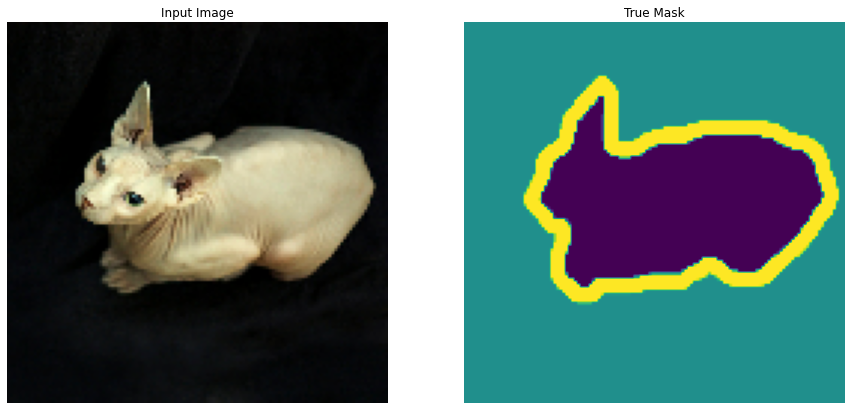

In [0]:
for img, mask in train.take(1):
  sampleImg, sampleMask = img, mask
display([sampleImg, sampleMask])

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
baseModel = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layerNames = ['block_1_expand_relu',
              'block_3_expand_relu',
              'block_6_expand_relu',
              'block_13_expand_relu',
              'block_16_project'
]
layers = [baseModel.get_layer(name).output for name in layerNames]

downStack = tf.keras.Model(inputs=baseModel.input, outputs = layers)
downStack.trainable = False

In [0]:
upStack = [pix2pix.upsample(512, 3),
           pix2pix.upsample(256, 3),
           pix2pix.upsample(128, 3),
           pix2pix.upsample(64, 3)
]

In [0]:
def unetModel(outputChan):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  skips = downStack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(upStack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
  
  last = tf.keras.layers.Conv2DTranspose(
      outputChan, 3, strides=2, padding='same')
  
  x = last(x)
  
  return tf.keras.Model(inputs=inputs, outputs=x)

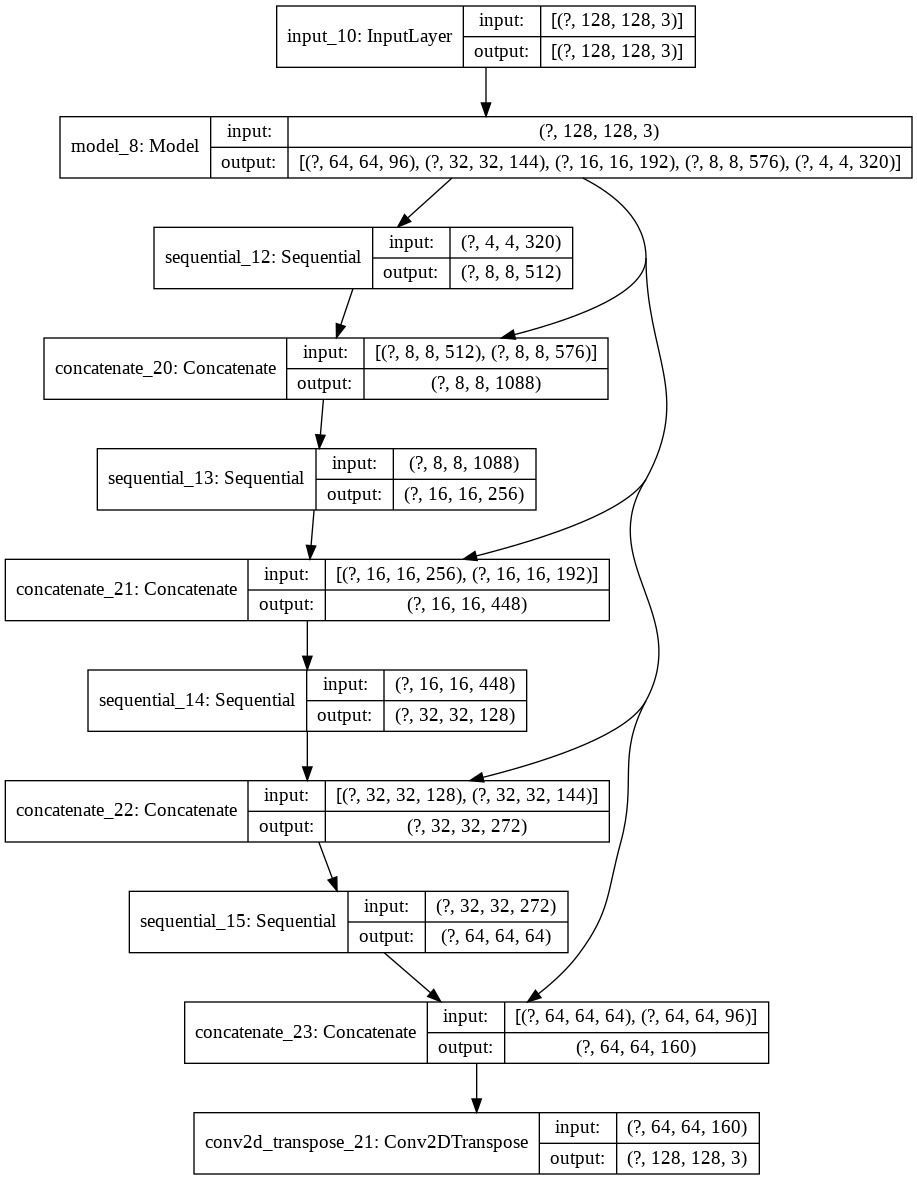

In [0]:
model = unetModel(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def createMask(predMask):
  predMask = tf.argmax(predMask, axis=-1)
  predMask = predMask[..., tf.newaxis]
  return predMask[0]

In [0]:
def showPreds(dataset=None, num=1):
  if dataset:
    for img, mask in dataset.take(num):
      predMask = model.predict(img)
      display([img[0], mask[0], createMask(predMask)])
  else:
    display([sampleImg, sampleMask, createMask(model.predict(sampleImg[tf.newaxis, ...]))])

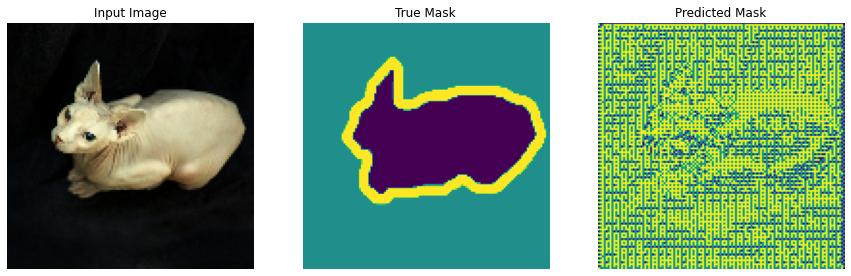

In [0]:
showPreds()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def onEpochEnd(self, epoch, logs=None):
    clear_output(wait=True)
    showPreds()
    print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [0]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples / BATCH_SIZE / VAL_SUBSPLITS

hist = model.fit(trainData,
                 epochs=EPOCHS,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_steps=VALIDATION_STEPS,
                 validation_data=testData,
                 callbacks=[DisplayCallback()])

Epoch 1/20
58/57 [==============================] - 325s 6s/step - loss: 0.5150 - accuracy: 0.7934 - val_loss: 0.4130 - val_accuracy: 0.8462
Epoch 2/20
58/57 [==============================] - 319s 5s/step - loss: 0.3021 - accuracy: 0.8760 - val_loss: 0.3172 - val_accuracy: 0.8713
Epoch 3/20
58/57 [==============================] - 317s 5s/step - loss: 0.2771 - accuracy: 0.8848 - val_loss: 0.2922 - val_accuracy: 0.8835
Epoch 4/20
58/57 [==============================] - 317s 5s/step - loss: 0.2599 - accuracy: 0.8910 - val_loss: 0.2771 - val_accuracy: 0.8893
Epoch 5/20
58/57 [==============================] - 316s 5s/step - loss: 0.2496 - accuracy: 0.8947 - val_loss: 0.2761 - val_accuracy: 0.8867
Epoch 6/20
58/57 [==============================] - 317s 5s/step - loss: 0.2384 - accuracy: 0.8988 - val_loss: 0.2790 - val_accuracy: 0.8861
Epoch 7/20
58/57 [==============================] - ETA: -2s - loss: 0.2333 - accuracy: 0.9003

KeyboardInterrupt: ignored

In [0]:
loss = hist.history['loss']
valLoss = hist.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, valLoss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [0]:
showPreds(testData, 3)